In [3]:
import pandas as pd 
import numpy as np 
import rasterio
from matplotlib import pyplot as plt
import math
import time
import io
import numpy as np
import csv
from IPython.display import Image, display
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from  torchvision.transforms import ToTensor, Compose, Normalize, Resize
from torch.utils.data import Dataset, DataLoader

code sourced from: https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L09/code/custom-dataloader/custom-dataloader-example.ipynb

tutorial at: https://www.youtube.com/watch?v=hPzJ8H0Jtew

### Split data into train, validation, test sets

In [26]:
df = pd.read_csv("./mlp_data/Q2_2022_ppt_target_full.csv")
df.drop("Unnamed: 0", inplace=True, axis=1)
print(df[:5],"\n", len(df), "\n", type(df))

                                 File Name  Discharge (Mean)
0  PRISM_ppt_stable_4kmD2_20220401_bil.tif             221.0
1  PRISM_ppt_stable_4kmD2_20220402_bil.tif             184.0
2  PRISM_ppt_stable_4kmD2_20220403_bil.tif             159.0
3  PRISM_ppt_stable_4kmD2_20220404_bil.tif             140.0
4  PRISM_ppt_stable_4kmD2_20220405_bil.tif             129.0 
 91 
 <class 'pandas.core.frame.DataFrame'>


In [27]:
train = df[:56]
valid = df[56:74]
test = df[74:]
print(len(train),len(valid),len(test))

56 18 17


In [28]:
train.to_csv("./mlp_data/Q2_2022_ppt_target_train.csv")
valid.to_csv("./mlp_data/Q2_2022_ppt_target_valid.csv")
test.to_csv("./mlp_data/Q2_2022_ppt_target_test.csv")

In [29]:
train_img_dir = os.listdir("./PPT_DATA_Clipped_Q2_2022_copy/train")
train_img_dir = pd.DataFrame(train_img_dir, columns=["File Name"])

valid_img_dir = os.listdir("./PPT_DATA_Clipped_Q2_2022_copy/validation")
valid_img_dir = pd.DataFrame(valid_img_dir, columns=["File Name"])

test_img_dir = os.listdir("./PPT_DATA_Clipped_Q2_2022_copy/test")
test_img_dir = pd.DataFrame(test_img_dir, columns=["File Name"])

print(len(train_img_dir), len(valid_img_dir), len(test_img_dir))

56 18 17


View Arguments for Custom Class

In [30]:

print(train_img_dir[:5], "\n", type(train_img_dir), "\n", train[0:5], "\n", type(train))

                                 File Name
0  PRISM_ppt_stable_4kmD2_20220401_bil.tif
1  PRISM_ppt_stable_4kmD2_20220402_bil.tif
2  PRISM_ppt_stable_4kmD2_20220403_bil.tif
3  PRISM_ppt_stable_4kmD2_20220404_bil.tif
4  PRISM_ppt_stable_4kmD2_20220405_bil.tif 
 <class 'pandas.core.frame.DataFrame'> 
                                  File Name  Discharge (Mean)
0  PRISM_ppt_stable_4kmD2_20220401_bil.tif             221.0
1  PRISM_ppt_stable_4kmD2_20220402_bil.tif             184.0
2  PRISM_ppt_stable_4kmD2_20220403_bil.tif             159.0
3  PRISM_ppt_stable_4kmD2_20220404_bil.tif             140.0
4  PRISM_ppt_stable_4kmD2_20220405_bil.tif             129.0 
 <class 'pandas.core.frame.DataFrame'>


In [31]:
class MyDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['File Name']
        self.y = df['Discharge (Mean)']
        self.transform = transform
    
    def __getitem__(self, idx):
        # Add channel for T-mean

        # Open the geospatial file using Rasterio
        with rasterio.open(os.path.join(self.img_dir + self.img_names[idx]), 'r') as src:
            data = src.read(1)  # Read the data (e.g., satellite imagery)
            # Apply any preprocessing or transformations here
            if self.transform:
                data = self.transform(data)
        discharge = self.y[idx]
        return data, discharge

    def __len__(self):
        return self.y.shape[0]

# Test the class

define transform

In [32]:
transform = Compose([ToTensor()])

create datasets

In [40]:
train_dataset = MyDataset(csv_path='./mlp_data/Q2_2022_ppt_target_train.csv',
                          img_dir='./PPT_DATA_Clipped_Q2_2022_copy/train/',
                          transform=transform)

In [41]:
valid_dataset = MyDataset(csv_path='./mlp_data/Q2_2022_ppt_target_valid.csv',
                          img_dir='./PPT_DATA_Clipped_Q2_2022_copy/validation/',
                          transform=transform)

In [42]:
test_dataset = MyDataset(csv_path='./mlp_data/Q2_2022_ppt_target_test.csv',
                          img_dir='./PPT_DATA_Clipped_Q2_2022_copy/test/',
                          transform=transform)

create loaders

In [68]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=1,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0)

In [69]:
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=1,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0)

In [70]:
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0)

In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)

Epoch: 1 | Batch index: 0 | Batch size: 1
Epoch: 1 | Batch index: 1 | Batch size: 1
Epoch: 1 | Batch index: 2 | Batch size: 1
Epoch: 1 | Batch index: 3 | Batch size: 1
Epoch: 1 | Batch index: 4 | Batch size: 1
Epoch: 1 | Batch index: 5 | Batch size: 1
Epoch: 1 | Batch index: 6 | Batch size: 1
Epoch: 1 | Batch index: 7 | Batch size: 1
Epoch: 1 | Batch index: 8 | Batch size: 1
Epoch: 1 | Batch index: 9 | Batch size: 1
Epoch: 1 | Batch index: 10 | Batch size: 1
Epoch: 1 | Batch index: 11 | Batch size: 1
Epoch: 1 | Batch index: 12 | Batch size: 1
Epoch: 1 | Batch index: 13 | Batch size: 1
Epoch: 1 | Batch index: 14 | Batch size: 1
Epoch: 1 | Batch index: 15 | Batch size: 1
Epoch: 1 | Batch index: 16 | Batch size: 1
Epoch: 1 | Batch index: 17 | Batch size: 1
Epoch: 1 | Batch index: 18 | Batch size: 1
Epoch: 1 | Batch index: 19 | Batch size: 1
Epoch: 1 | Batch index: 20 | Batch size: 1
Epoch: 1 | Batch index: 21 | Batch size: 1
Epoch: 1 | Batch index: 22 | Batch size: 1
Epoch: 1 | Batch inde

Feature batch shape: torch.Size([1, 1, 8, 8])
Labels batch shape: torch.Size([1])


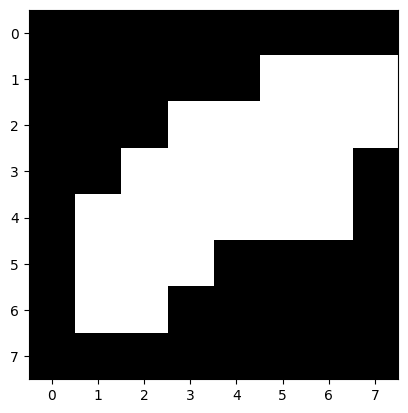

Label: 594.0


In [72]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [73]:
print(x.shape)

torch.Size([1, 1, 8, 8])


In [74]:
x_image_as_vector = x.view(-1, 8*8)
print(x_image_as_vector.shape)

torch.Size([1, 64])


## Build a basic Regression MLP with current dataset

In [75]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic
# from helper_train import train_model
# from helper_plotting import plot_training_loss, plot_accuracy, show_examples
# from helper_dataset import get_dataloaders

In [76]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Corresponding Discharge dimensions:', labels.shape)
    print('Discharge of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([1, 1, 8, 8])
Corresponding Discharge dimensions: torch.Size([1])
Discharge of 10 examples: tensor([132.], dtype=torch.float64)


In [77]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 1
BATCH_SIZE = 5
NUM_EPOCHS = 10
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [78]:
set_all_seeds(RANDOM_SEED)
set_deterministic()

In [79]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden, batch_size):
        super().__init__()
        
        self.num_classes = batch_size
        
        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden, batch_size))

    def forward(self, x):
        return self.model(x)

In [80]:
#################################
### Model Initialization
#################################
    
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=8*8,
            num_hidden=100,
            batch_size=5)

model = model.to(DEVICE)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

training loop

In [81]:
# Run the training loop
train_loss_list = []
for epoch in range(0, 5): # 5 epochs at maximum

    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0
    

    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_loader, 0):
        
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()

        # Track loss
        train_loss_list.append(loss)
        
        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
            current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 5362.766
Loss after mini-batch    11: 55092763936217808337632038486016.000
Loss after mini-batch    21: 297731639574920501325495009280.000
Loss after mini-batch    31: 131598106686792849478758957056.000
Loss after mini-batch    41: 58166694818316421470537908224.000
Loss after mini-batch    51: 25709823891256478164599177216.000
Starting epoch 2
Loss after mini-batch     1: 1061499733764264401397874688.000


c:\Users\19195\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after mini-batch    11: 6962714906329823725213450240.000
Loss after mini-batch    21: 3077537336003272645527207936.000
Loss after mini-batch    31: 1360279270995205600430784512.000
Loss after mini-batch    41: 601246761003622137063276544.000
Loss after mini-batch    51: 265752561018643613615128576.000
Starting epoch 3
Loss after mini-batch     1: 10972314630884997831065600.000
Loss after mini-batch    11: 71970909393324667247263744.000
Loss after mini-batch    21: 31811317921391753214033920.000
Loss after mini-batch    31: 14060677378142605999603712.000
Loss after mini-batch    41: 6214852700906286294761472.000
Loss after mini-batch    51: 2746979996518886408192000.000
Starting epoch 4
Loss after mini-batch     1: 113416467076525844332544.000
Loss after mini-batch    11: 743934831038888889286656.000
Loss after mini-batch    21: 328821039145046029369344.000
Loss after mini-batch    31: 145339703700055792812032.000
Loss after mini-batch    41: 64240510111993156337664.000
Loss after 